# Dataset: PAN-12

The dataset has been created for the PAN-12 international competition [[1](#bib-1)] using the chats, gathered by the non-profit organization Perverted-Justice Foundation, occurred between experts who
posed as minors and convicted predators. It contains a total of 155128 conversations, stored in
a single XML file, collected from publicly available IRC chat logs containing conversations
mainly about computers and web technologies. For this reason, performances are expected to
decrease in real world applications, where conversation topics are heterogeneous [[2](#bib-2)].

## Setup

The necessary modules are imported, the corpus to parse is chosen, and the logger is initialized.

In [1]:
from Classification import Benchmark, ClassifierType, MetricType, FeatureExtraction, FeatureExtractionStep
from Data import Dataset
from PreProcessing import CorpusName, CorpusParser
from Utils import Log, Time
from Utils.Log import LogOutput, LogLevel

# Select corpus name.
corpus_name = CorpusName.PAN12
corpus_path = "./datasets/pan12"

# Initialize logger.
output_path = f'./out/{Time.get_timestamp("%Y-%m-%d")}_{corpus_name}'
Log.init(path=output_path)

[2019-07-08 00:38:10] Logger initialized.


## Corpus parser and dataset container

The parser and the dataset container are initialized. 

The _merge messages_ method, discussed in [section 3.3.1](https://stefanofrazzetto.com/wp-content/uploads/2019/04/Stefano-Frazzetto-Dissertation.pdf#subsection.3.3.1) of my dissertation [[3](#bib-3)], is not used as it does not improve the results obtained.

In [2]:
parser = CorpusParser.factory(
    corpus_name=corpus_name, 
    source_path=corpus_path, 
    merge_messages=False,
    deserialize=True
)

dataset = Dataset(parser.get_params(), corpus_name=corpus_name)

parser.parse()
parser.log_info()

[2019-07-08 00:38:10] Parsing PAN12 corpus... 
[2019-07-08 00:38:10] Loading ground truth files... done.
[2019-07-08 00:38:10] Problem files parsed successfully.
[2019-07-08 00:38:45] Parsing done.
[2019-07-08 00:38:45] Serializing 'pan12parser_26084d73cd79e79d011fa51aa61639c0859f95571851baa10b899a32af9c9502.dat'...
[2019-07-08 00:38:54] Done serializing.


Element,Total,No. Flagged,Flagged %
Conversations,155128,834,0.54
Messages,2058781,6478,0.31
Authors,218702,254,0.12


## Populating the dataset

The dataset is populated with the samples extracted using the parser.

In [3]:
parser.add_to_dataset(dataset)
dataset.finalize()
dataset.log_info()

Subset,Positive,Negative,Positive %,% of total samples
Training,5522,1.74444e+06,0.32,85
Testing,956,307861,0.31,15
Total,6478,2.0523e+06,0.31,100


## Balance subsets
Training and testing subsets are balanced with a samples ratio of 5:1 (negative samples over positives), if achievable.

In [4]:
dataset.balance_all(5)
dataset.log_info()

[2019-07-08 00:39:03] Dropping majority class samples for the training subset.
[2019-07-08 00:39:04] Dropping majority class samples for the testing subset.


Subset,Positive,Negative,Positive %,% of total samples
Training,5522,27610,16.67,85.24
Testing,956,4780,16.67,14.76
Total,6478,32390,16.67,100


## Initialize feature extraction pipeline

The feature extraction pipeline is initialized:

The dataset is transformed into training data for the machine learning algorithms by tokenizing the words using a Snowball stemmer, vectorizing it, and applying Term Frequency--Inverse Document Frequency (TF-IDF). The number of features for the vectorization process is intentionally left unbounded to make use of all the features available. 

In [5]:
feature_extraction = FeatureExtraction(
    FeatureExtractionStep.TOKENIZE,
    FeatureExtractionStep.TFIDF,
    dataset=dataset,
    max_features=None,
)

[nltk_data] Downloading package punkt to /home/stefano/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


[2019-07-08 00:39:04] Extracting features using the following pipeline:
[2019-07-08 00:39:04] 	- Tokenizer
[2019-07-08 00:39:04] 	- CountVectorizer
[2019-07-08 00:39:09] 	- TF-IDF


## Initialize classifiers
Classifiers are added to the benchmark and initialized with the data extracted using the previously created pipeline.

In [6]:
benchmark = Benchmark(dataset=dataset, feature_extraction=feature_extraction)
benchmark.add_classifier(ClassifierType.RandomForest)
benchmark.add_classifier(ClassifierType.MultiLayerPerceptron)
benchmark.add_classifier(ClassifierType.SupportVectorMachine)
benchmark.add_classifier(ClassifierType.MultinomialNaiveBayes)
benchmark.add_classifier(ClassifierType.LogisticRegression)
benchmark.initialize_classifiers()

[2019-07-08 00:39:10] Initializing classifiers...
[2019-07-08 00:42:16] Classifiers initialized correctly.


## Run benchmark
The benchmark is run on the testing subset. This subset is split into five smaller subsets.

To generate the evaluation metrics, the testing is split into five smaller subsets, and classifiers are evaluated on each of them. This is done to create a more balanced estimate of the results.

In [7]:
benchmark.run(5)

[2019-07-08 00:42:16] Starting benchmarking process.
[2019-07-08 00:42:26] Benchmark process completed.


## Plots

The results obtain are finally plotted. As it can be seen from the graphic below, the Multi-Layer Perceptron (MLP) produced the highest results, with the highest value for the Matthews Correlation Coefficient almost reaching 0.8.

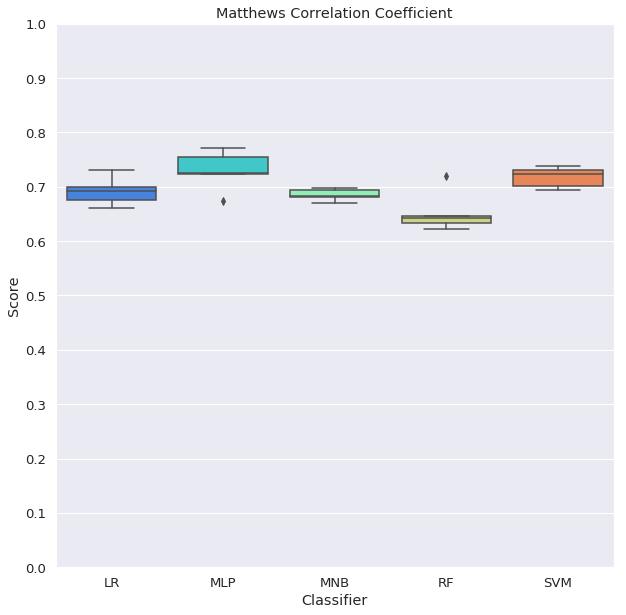

In [9]:
benchmark.plot_metrics(MetricType.MCC)

# Bibliography

<a id="bib-1">1.</a> G. Inches and F. Crestani, “Overview of the International Sexual Predator Identification
Competition at PAN-2012,” in CLEF 2012 Evaluation Labs and Workshop – Working
Notes Papers, 17-20 September, Rome, Italy, P. Forner, J. Karlgren, and C. Womser-
65
Hacker, Eds., Sep. 2012, ISBN: 978-88-904810-3-1. \[Online\]. Available: http://www.clef-initiative.eu/publication/working-notes.

<a id="bib-2">2.</a> M. Ebrahimi, C. Y. Suen, and O. Ormandjieva, “Detecting predatory conversations in
social media by deep convolutional neural networks,” Digital Investigation, vol. 18, Jul.2016. DOI: [10.1016/j.diin.2016.07.001](https://doi.org/10.1016/j.diin.2016.07.001).

<a id="bib-3">3.</a> S. Frazzetto, "Automated Crime Detection and Classification in Online Chats using Machine Learning", May 2019. \[Online\]. Available: https://stefanofrazzetto.com/dissertation/